# EnvErgo project
- [researchgate link](https://www.researchgate.net/project/Isokinetic-measurements-and-musculoskeletal-modelling-for-ergonomics)
- [github link](https://github.com/romainmartinez/envergo)

_Romain Martinez_

# Statistical Parametric Mapping

- To non-parametrically analyze 2D-1D data, for example, just flatten all of the 2D continua into 1D vectors, then use spm1d to run non-parametric analysis to compute a critical threshold. 
- Afterwards you can reshape the 1D test-statistic continuum (or, conventionally, the 1D "statistical parametric map") back into its original 2D form, and then visualize regions of the 2D continuum that survive the critical threshold.
- One caveat is that this pertains only to continuum-level inference (i.e. a critical threshold). For 1D-nD continua spm1d also computes cluster-level and set-level probabilities. spm1d is currently unable compute cluster-level and set-level inferences for mD continua where m > 1.

## Data description
- 3 files for each position:
    1. `participant_position_CVP`: `Couple_ext`, `Couple_flex`, `Position`, `Vitese` (441, 1 each)
    2. `participant_position_Flex_meshdata`: `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh`(21, 21)
    3. `participant_position_Ext_meshdata`: `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh` (21, 21)
- We will use `Angle4mesh` (1, 21), `Velocity4mesh` (1, 21), `torque4mesh`(21, 21) to generate mesh and do the stats

In [1]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import spm1d

In [2]:
data_path = '/home/romain/Desktop/envergo'
files = os.listdir(data_path)

torque = {}

for ifile in files:
    if ifile.endswith('meshdata.mat'):
        participant, position, contraction, ext = ifile.split('_')

        mat = sio.loadmat(os.path.join(data_path, ifile))['Torque4mesh']
        if not position in torque:
            torque[position] = {}
        if contraction in torque[position]:
            torque[position][contraction] = np.dstack((torque[position][contraction], mat))
        else:
            torque[position][contraction] = mat


torque['Abd90ER']['Flex'].shape

(21, 21, 2)

In [73]:
x = np.arange(1, 22)
y = np.arange(1, 22)
z = np.random.rand(441).reshape(21, 21)

reshape_x = np.tile(x, 21)
reshape_y = np.repeat(y, 21)
reshape_z = z.flatten()



import pandas as pd
xi = pd.DataFrame({
    'velocity': reshape_x,
    'angle': reshape_y,
    'torque': reshape_z
})
xi.head()

,angle,torque,velocity
0,1,0.512957,1
1,1,0.731175,2
2,1,0.101803,3
3,1,0.362116,4
4,1,0.670373,5


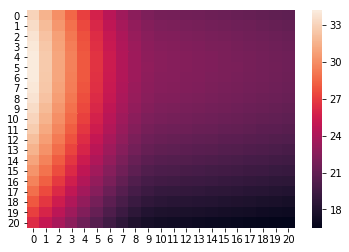

In [7]:
import seaborn as sns
sns.heatmap(torque['Abd90ER']['Ext'][:, :, 1])
plt.show()

In [84]:
# create spm matrix
angle, velocity, participant = torque['Abd90ER']['Ext'].shape
position = len(torque.keys())

participants, positions, y = ([] for i in range(3))

for iparticipant in range(participant):
    for iposition, position_name in enumerate(torque.keys()):
        participants.append(iparticipant + 1)
        positions.append(iposition + 1)
        y.append(torque[position_name]['Ext'][:, :, iparticipant].flatten())

participants, positions, y = [np.array(i) for i in [participants, positions, y]]
print('participant: {}'.format(participants))
print('position: {}'.format(positions))
print('y.shape: {}'.format(y.shape))

participant: [1 1 1 1 1 1 2 2 2 2 2 2]
position: [1 2 3 4 5 6 1 2 3 4 5 6]
y.shape: (12, 441)


In [85]:
participants.shape

(12,)

SnPM{F} inference field
   SPM.effect         :  Main A
   SPM.z              :  (1x441) raw test stat field
   SnPM.nPermUnique   :  4.79e+08 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  20.44804
   SPM.h0reject       :  False
   SPM.p              :  ()



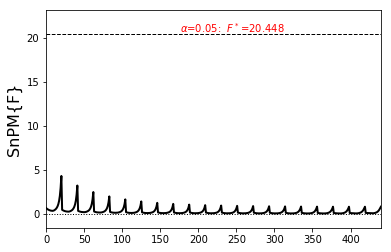

In [88]:
alpha = 0.05
spm = spm1d.stats.nonparam.anova1rm(y, positions, participants)
spmi = spm.inference(alpha, iterations=10000)
print(spmi)

f = plt.figure()
spmi.plot()
spmi.plot_p_values()
spmi.plot_threshold_label()
plt.show()
f.savefig('foo.png', bbox_inches='tight')

SnPM{F} inference field
   SPM.effect         :  Main A
   SPM.z              :  (1x101) raw test stat field
   SnPM.nPermUnique   :  2.653e+32 permutations possible
Inference:
   SPM.alpha          :  0.050
   SPM.zstar          :  7.66232
   SPM.h0reject       :  True
   SPM.p              :  (<0.001, <0.001, 0.002, 0.002)

SPM{F} inference field
   SPM.effect    :   Main A
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (2, 18)
   SPM.fwhm      :  5.88283
   SPM.resels    :  (1, 16.99861)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  10.41185
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (<0.001, <0.001, <0.001, <0.001)





/home/romain/miniconda3/envs/envergo/lib/python3.6/site-packages/spm1d/stats/anova/ui.py:118: UserWarning: 

  if ((model.dim == 1) or _force_approx0D)   and   ( design.check_for_single_responses(dim=model.dim) ):


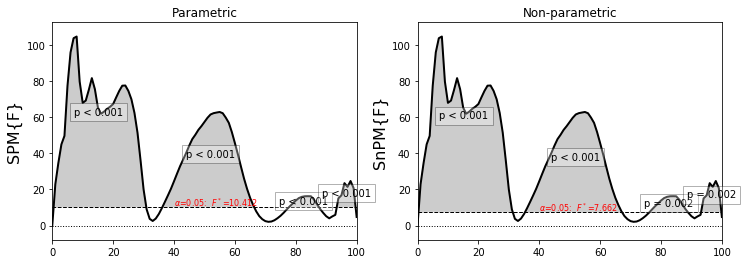

In [69]:
#(0) Load dataset:
dataset      = spm1d.data.uv1d.anova1rm.SpeedGRFcategoricalRM()
y,A,SUBJ     = dataset.get_data()


#(1) Conduct non-parametric test:
np.random.seed(0)
alpha      = 0.05
snpm       = spm1d.stats.nonparam.anova1rm(y, A, SUBJ)
snpmi      = snpm.inference(alpha, iterations=500)
print( snpmi )




#(2) Compare with parametric result:
spm        = spm1d.stats.anova1rm(y, A, SUBJ, equal_var=True)
spmi       = spm.inference(alpha)
print( spmi )




#(3) Plot
plt.close('all')
plt.figure(figsize=(12,4))

ax0 = plt.subplot(121)
ax1 = plt.subplot(122)
labels = 'Parametric', 'Non-parametric'
for ax,zi,label in zip([ax0,ax1], [spmi,snpmi], labels):
	zi.plot(ax=ax)
	zi.plot_threshold_label(ax=ax, fontsize=8)
	zi.plot_p_values(ax=ax, size=10)
	ax.set_title( label )
plt.show()

In [70]:
y.shape

(30, 101)

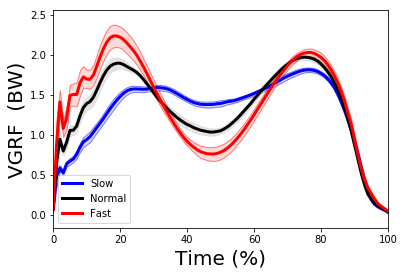

In [37]:
dataset = spm1d.data.uv1d.anova1.SpeedGRFcategorical()
Y,A     = dataset.get_data()
Y0      = Y[A==1]
Y1      = Y[A==2]
Y2      = Y[A==3]

plt.close('all')
spm1d.plot.plot_mean_sd(Y0, linecolor='b', facecolor=(0.7,0.7,1), edgecolor='b', label='Slow')
spm1d.plot.plot_mean_sd(Y1, label='Normal')
spm1d.plot.plot_mean_sd(Y2, linecolor='r', facecolor=(1,0.7,0.7), edgecolor='r', label='Fast')
plt.xlim(0, 100)
plt.xlabel('Time (%)', size=20)
plt.ylabel('VGRF  (BW)', size=20)
plt.legend(loc='lower left')
plt.show()

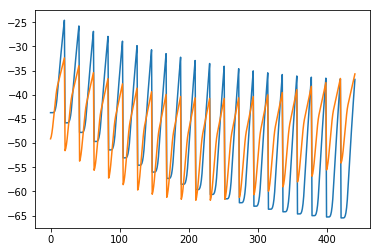

In [43]:
for i in range(2):
    plt.plot(torque['Abd90ER']['Flex'][:, :, i].flatten())
plt.show()